In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Sequential feature selection and Lasso 

In [ ]:
# Number of observations
N = 500

# Numbers of predictors
p = 10

# True variance in regression
sigma2 = 1

# Generate some random x's
x = np.random.normal(size=(N,p))
# give some names
names = pd.DataFrame(['feature_'+str(i) for i in range(p)])

# Define the relevant (true) x's
true_x_idx = [0, 1, 2, 3]
true_B = np.array([0.5, 1, -5, 5]).reshape((1,4))

# Generate y 
y = np.dot(x[:,true_x_idx],np.transpose(true_B)) + \
              np.random.normal(size=(N,1))*np.sqrt(sigma2)

## Forward feature selection
It is a greedy procedure that iteratively finds the best new feature to add to the set of selected features. Concretely, we initially start with zero feature and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached, as determined by the `n_features_to_select` parameter.


In [ ]:
linear_base = LinearRegression()
forward_selection = sfs(estimator=linear_base, n_features_to_select=6,\
                direction='forward', scoring='neg_mean_squared_error').fit(x,y)
print("Features selected by forward sequential selection: {}".\
      format(names[forward_selection.get_support()]))

Features selected by forward sequential selection:            0
0  feature_0
1  feature_1
2  feature_2
3  feature_3
6  feature_6
8  feature_8


Now use the chosen features and fit a OLS model using the `statsmodels` library.

In [ ]:
# only the features selected by the forward approach
x_fs = x[:,forward_selection.get_support()]
forward_lr = sm.OLS(y,sm.add_constant(x_fs)).fit()
print(forward_lr.summary())


## Backward feature selection
It follows the same idea as the forward approach, but works in the opposite direction: instead of starting with no feature and greedily adding features, it starts with all the features and greedily remove features from the set. The `direction` parameter in the function controls whether forward or backward is used.



In [ ]:
backward_selection = sfs(estimator=linear_base, n_features_to_select=6,\
                direction='backward', scoring='neg_mean_squared_error').fit(x,y)
print("Features selected by backward sequential selection: {}".\
      format(names[backward_selection.get_support()]))

In [ ]:
# only the features selected by the backward approach
x_bs = x[:,backward_selection.get_support()]
backward_lr = sm.OLS(y,sm.add_constant(x_bs)).fit()
print(backward_lr.summary())

**Note:** In general, forward and backward selection do not yield equivalent results. Also, one may be much faster than the other depending on the requested number of selected features: if we have 10 features and ask for 7 selected features, forward selection would need to perform 7 iterations while backward selection would only need to perform 3.

## Least Absolute Shrinkage and Selection Operator (LASSO)

In [ ]:
# For LASSO, select the penalty term L1_wt to be 1 
from sklearn.linear_model import Lasso
lassoreg = Lasso().fit(x,y)
lasso_coeff = []
lasso_coeff.extend(lassoreg.intercept_)
lasso_coeff.extend(lassoreg.coef_[lassoreg.coef_!=0])
print("Features selected by LASSO:\n{}\nwith coefficients {}".\
      format('intercept\n'+names[lassoreg.coef_!=0].to_string(index=False,\
            header=False), np.round(lasso_coeff,4)))

Features selected by LASSO:
intercept
feature_2
feature_3
with coefficients [ 0.1348 -3.9256  4.0091]


### Cross-valitation with LASSO

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Choose different values for the hyperparameter alpha
alphas = [1e-15, 1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5, 10]

# for each alpha value, we conduct a 5-folds CV
cv = 5

# save mean squared errors in a matrix
all_scores = np.zeros((len(alphas),cv))

for i,alpha in enumerate(alphas):
  kfolds = KFold(n_splits=cv, shuffle=True)
  all_scores[i,:] = cross_val_score(Lasso(alpha=alpha),x,y,cv=kfolds,\
                           scoring='neg_mean_squared_error')

print('Average mse {} with std {}'.\
      format(np.round(-1*np.mean(all_scores,axis=1),4),\
             np.round(np.std(all_scores,axis=1),4)))


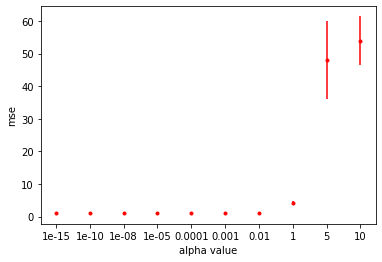

In [ ]:
avg_mse = -1*np.mean(all_scores,axis=1)
std_mse = np.std(all_scores,axis=1)
plt.errorbar(range(10),avg_mse, yerr=std_mse, fmt='.', color='r')
plt.xticks(range(10), [str(a) for a in alphas])
plt.xlabel('alpha value')
plt.ylabel('mse')
plt.show()

### Effect of the hyperparameter λ on $\beta$

In [ ]:
# create a LASSO model for different alpha values
# and fit the model
lasso_1 =  Lasso(alpha=alphas[0]).fit(x,y)
lasso_2 =  Lasso(alpha=alphas[5]).fit(x,y)
lasso_3 =  Lasso(alpha=alphas[7]).fit(x,y)
# get predicted values based on the fitted model
y_pred1 = lasso_1.predict(x)
y_pred2 = lasso_2.predict(x)
y_pred3 = lasso_3.predict(x)
# get sum of squared residuals (rss)
rss1 = np.round(np.sum((y_pred1 -y)**2),1)
rss2 = np.round(np.sum((y_pred2 -y)**2),1)
rss3 = np.round(np.sum((y_pred3 -y)**2),1)

# create a list with: i) rss and ii) model coefficients
results1 = [rss1]
results1.extend(np.round(lasso_1.intercept_.tolist(),3))
results1.extend(np.round(lasso_1.coef_.tolist(),3))
results2 = [rss2]
results2.extend(np.round(lasso_2.intercept_.tolist(),3))
results2.extend(np.round(lasso_2.coef_.tolist(),3))
results3 = [rss3]
results3.extend(np.round(lasso_3.intercept_.tolist(),3))
results3.extend(np.round(lasso_3.coef_.tolist(),3))

# create a data frame for easy visualization of retults
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(p)]
ind = ['alpha_%.2g'%alphas[i] for i in [0,5,7]]
matrix_lasso = pd.DataFrame(index=ind, columns=col)

# just append the results row-wise
matrix_lasso.iloc[0,:] = results1
matrix_lasso.iloc[1,:] = results2
matrix_lasso.iloc[2,:] = results3
# save as csv. It is easier to see all coefficients
matrix_lasso.to_csv('lasso_coeff.csv', sep=';')
print(matrix_lasso)


Alternatively use `LassoCV` that saves the best model in the CV.

In [ ]:
from sklearn.linear_model import LassoCV

# define the LassoCV object
Lasso = LassoCV(cv=cv, fit_intercept=True).fit(x,y.ravel())
print('The optimal alpha is {:.4f}:'.format(Lasso.alpha_))

# compute the path
[alphas,weights,c] = Lasso.path(x, y.ravel())

# plot coeffs as a function of alpha
fig = plt.figure()
plt.plot(alphas, weights.T)
plt.show()